In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def hurst_rs(x, min_chunksize, max_chunksize, num_chunksize):
    N = len(x)
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),
                np.nanstd(chunk)
            )

        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list,),
        rcond = None
    )[0]
    
    return H

def hurst_exponent(prices, min_chunksize=8, max_chunksize=100, num_chunksize=5):
    if len(prices) == 0:
        return np.nan
    arr = prices.__array__()
    if prices.ndim > 1:
            h = hurst_rs(np.diff(arr, axis=0).T, min_chunksize, max_chunksize,
                         num_chunksize)
    else:
            h = hurst_rs(np.diff(arr), min_chunksize, max_chunksize,
                         num_chunksize)
    return h

def plotDayAvg(rollHurst, comSymList, numDays = 50):
    fig, axs = plt.subplots(2,2, figsize=(15,8))
    for ax, com in zip(axs.flat, comSymList):
        rollHurst[com][::numDays].plot(ax=ax)
        ax.set_title(com)
        ax.set_yticks(np.arange(11)/10)
        ax.grid(True, linestyle='--')
        ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
    fig.set_tight_layout(True)
    
def plotDayAvgSingle(rollHurst, comSym, numDays = 50):
    fig = plt.figure()
    plt.plot(figsize = (15,8))
    rollHurst[comSym][::numDays].plot()
    plt.title(comSym)
    plt.yticks(np.arange(11)/10)
    plt.grid(True, linestyle='--')
    plt.axhline(0.5, linestyle='--', color='k', alpha=0.5)
    fig.set_tight_layout(True)
        
def plotRollDayMean(rollHurst, comSymList, rollDays = 50):
    fig, axs = plt.subplots(2,2, figsize=(15,8))
    for ax, com in zip(axs.flat, comSymList):
        rollHurst[com].rolling(rollDays).mean().plot(ax=ax)
        ax.set_title(com)
        ax.set_yticks(np.arange(11)/10)
        ax.grid(True, linestyle='--')
        ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
    fig.set_tight_layout(True)
    
def plotRollDayMeanSingle(rollHurst, comSym, rollDays = 50):
    fig = plt.figure()
    plt.plot(figsize = (15,8))
    rollHurst[comSym].rolling(rollDays).mean().plot()
    plt.title(comSym)
    plt.yticks(np.arange(11)/10)
    plt.grid(True, linestyle='--')
    plt.axhline(0.5, linestyle='--', color='k', alpha=0.5)
    fig.set_tight_layout(True)
    

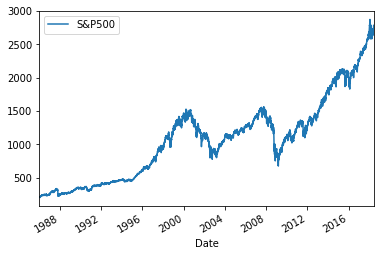

In [27]:
spx_df = pd.read_csv("spx.csv")
nameVal = ["Date","Close"]
aapl_df = pd.read_table("aapl.txt", sep = ',')[nameVal]
amzn_df = pd.read_table("amzn.txt", sep = ',')[nameVal]
msft_df = pd.read_table("msft.txt", sep = ',')[nameVal]
fb_df = pd.read_table("fb.txt", sep = ',')[nameVal]
companies = []

for df in [aapl_df,amzn_df,msft_df,fb_df,spx_df]:
    df.columns = nameVal
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace = True)
    
comSymList = ["Apple","Amazon","Microsoft","Facebook"]
allSymList = ["S&P500","Apple","Amazon","Microsoft","Facebook"]
comList = [aapl_df,amzn_df,msft_df,fb_df]
allList = [spx_df,aapl_df,amzn_df,msft_df,fb_df]
companies = pd.concat(comList, axis = 1)
allCom = pd.concat(allList, axis = 1)
companies.columns = comSymList
allCom.columns = allSymList
start = "2012"
end = "2017"

companies = companies.where(companies != 0., np.nan)
companies = companies.loc[start:end]
allCom = allCom.where(allCom != 0., np.nan)
allCom = allCom.loc[start:end]

def plotCom(prices):
    kw = dict(figsize=(16,8), grid=True, subplots=True, layout=(2,2), linewidth=0.75)
    axs = prices.plot(**kw)
    [ax.set_ylabel('In dollars ($)') for ax in axs.flat[::2]]
    plt.suptitle('Close Price by Company', y=0.95);
    
spx_df.columns = ["S&P500"]
spx_df.plot()

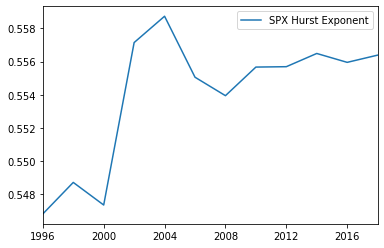

In [36]:
def plotDFHurstOverYears(df, name = ""):
    years = ["1996","1998","2000","2002","2004","2006","2008","2010","2012","2014","2016","2018"]
    customDF = []
    for year in years:
        customDF.append(df.loc["1988":year])

    customDF = pd.concat(customDF, axis = 1)
    customDF.columns = years

    hurstExp = customDF.apply(lambda x: hurst_exponent(x.dropna()))
    hurstExp = pd.concat([hurstExp], axis = 1)
    hurstExp.columns = [name + " Hurst Exponent"]
    hurstExp.plot()
    
plotDFHurstOverYears(spx_df, "SPX")

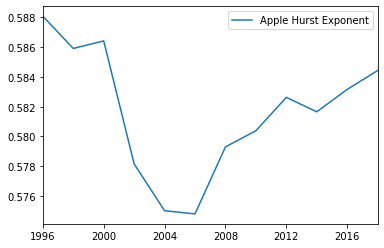

In [37]:
plotDFHurstOverYears(aapl_df, "Apple")

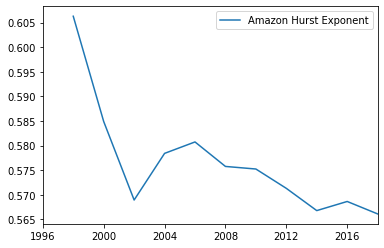

In [38]:
plotDFHurstOverYears(amzn_df, "Amazon")

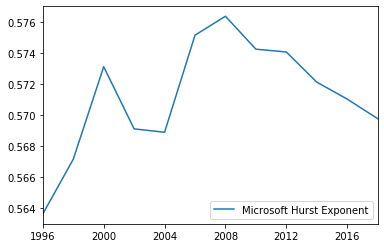

In [39]:
plotDFHurstOverYears(msft_df, "Microsoft")

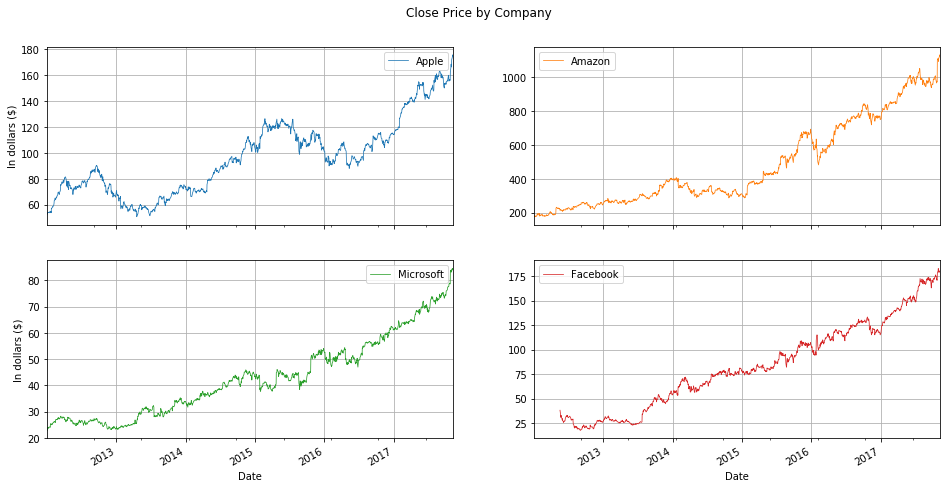

In [4]:
plotCom(companies)

In [5]:
hurstExp = allCom.apply(lambda x: hurst_exponent(x.dropna()))
hurstExp = pd.concat([hurstExp], axis = 1)
hurstExp.columns = ["Hurst Exponent"]
hurstExp

,Hurst Exponent
S&P500,0.557201
Apple,0.592904
Amazon,0.560250
Microsoft,0.539048
Facebook,0.582192


In [6]:
rollDays = 250
rollPrices = allCom.rolling(250)
rollHurst = rollPrices.apply(lambda s: hurst_exponent(s),raw = False).dropna()
rollHurst[::100].head()

,S&P500,Apple,Amazon,Microsoft,Facebook
Date,,,,,
2013-05-17,0.487676,0.474797,0.509512,0.460543,0.585289
2013-10-09,0.587107,0.556741,0.551898,0.501372,0.596528
2014-03-05,0.565753,0.598159,0.533761,0.504886,0.600069
2014-07-28,0.545887,0.566838,0.499496,0.492338,0.595144
2014-12-17,0.581322,0.507111,0.514468,0.542874,0.519883


In [7]:
rollHurst[::100].mean()

S&P500       0.557902
Apple        0.580294
Amazon       0.552062
Microsoft    0.523684
Facebook     0.569275
dtype: float64

In [8]:
rollHurst[::50].mean()

S&P500       0.563955
Apple        0.593804
Amazon       0.554723
Microsoft    0.525269
Facebook     0.565725
dtype: float64

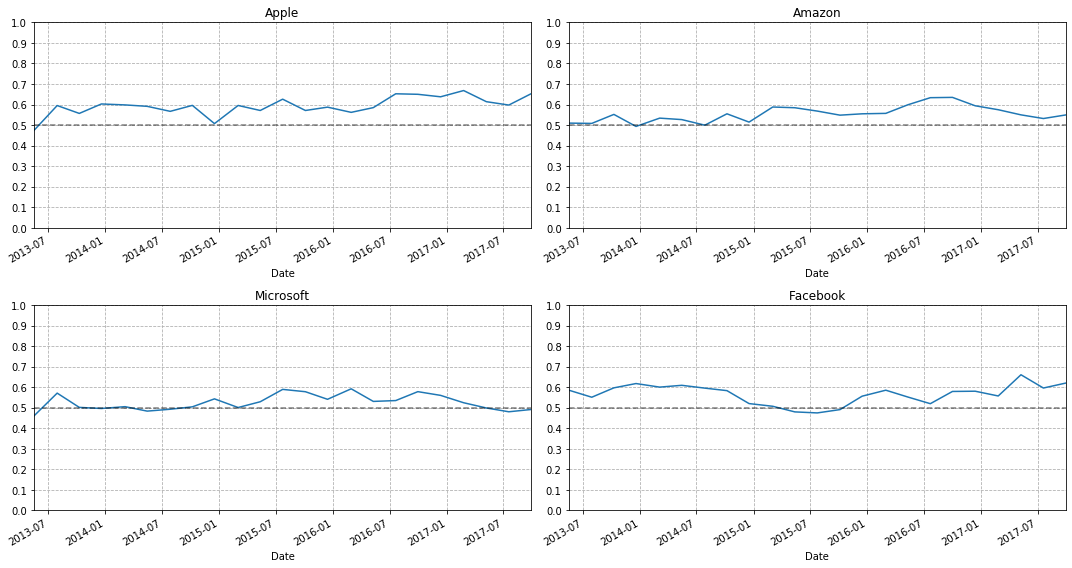

In [25]:
plotDayAvg(rollHurst, comSymList)

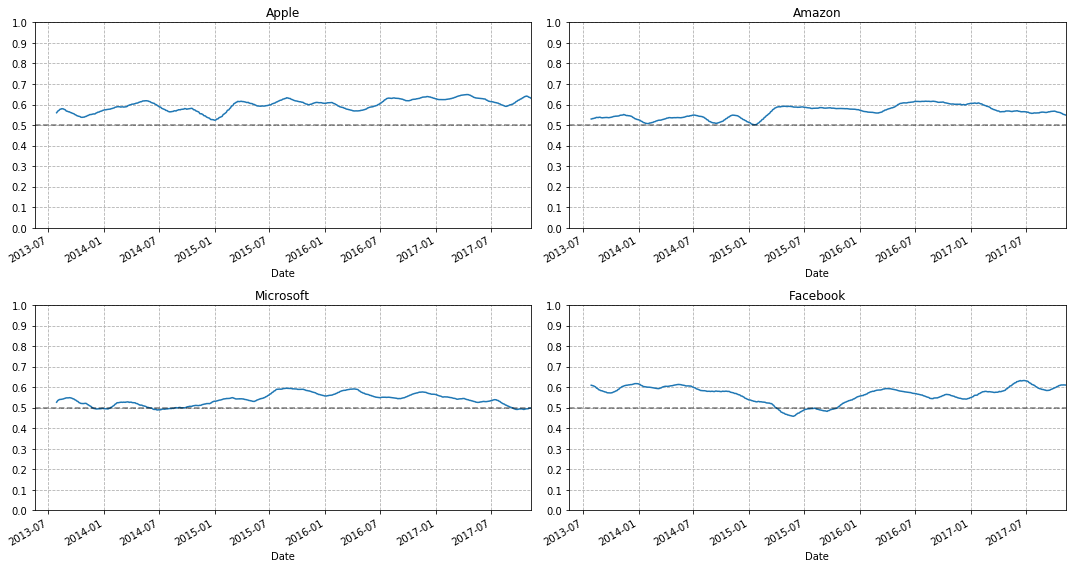

In [16]:
plotRollDayMean(rollHurst, comSymList)

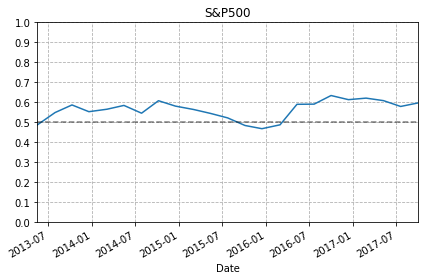

In [17]:
plotDayAvgSingle(rollHurst, "S&P500")

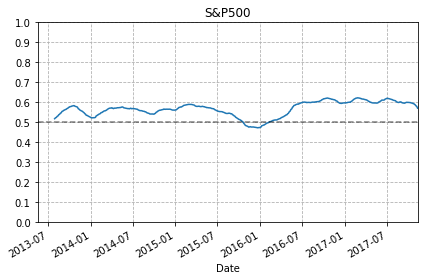

In [18]:
plotRollDayMeanSingle(rollHurst, "S&P500")